In [4]:
# import libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

%matplotlib inline


import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
#tf.random.set_seed(42)
np.random.seed(42)




In [11]:
from Code.OtherFunctions import *

In [206]:
# Configurations

Settings=["Base", "Random", "Energy","Gamma"]
Model_types=["True", "Complex", "Simple"]
Param_array = [{'alpha' : 1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}, 
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2}, 
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 0.0, 'omega' : 1.2},
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2}, 
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.0, 'delta' : 0.3, 'omega' : 0.0},
          {'alpha' : -1.0, 'beta' : -1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : 0.0, 'beta' : 0.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}]

In [207]:
i = 0
j = 1
k = 8

feature_setting = Settings[i]
model_setting = Model_types[0]
params = {'alpha' : -2.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}#Param_array[k]

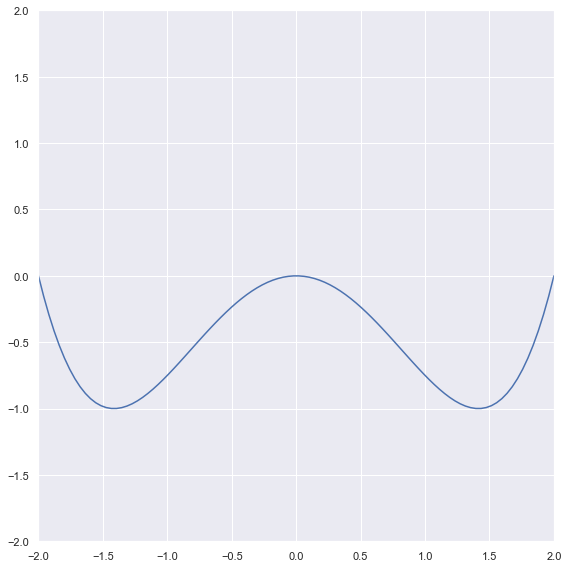

In [208]:
f, axs = plt.subplots(1, 1, figsize=(8, 8), gridspec_kw=dict(width_ratios=[4]))

x_potential = np.linspace(-2,2,100)
v_potential = 0
y_potential = (0.5*v_potential**2 + 0.5*params['alpha']*x_potential**2 +0.25*params['beta']*x_potential**4)

sns.lineplot(x = x_potential, y=y_potential,ax=axs)
axs.set(xlim=(-2, 2), ylim=(-2, 2))
f.tight_layout()


In [209]:
if feature_setting == "Base":
    from Code.BaseDuffing import Duffing
elif feature_setting == "Random":
    from Code.RandomDuffing import Duffing
elif feature_setting == "Energy":
    from Code.EnergyDuffing import Duffing
elif feature_setting == "Gamma":
    from Code.GammaDuffing import Duffing

In [210]:
# load dataset

duffing = Duffing(parameters = params)
eom = duffing.eom


features = duffing.features
labels = duffing.labels

In [211]:
big_df = pd.DataFrame()
for j in Model_types:
    suffix = feature_setting + "_" + model_setting + "_" + duffing.suffix
    temp_df = pd.read_csv("Results/ArrayRuns/Results/explainer_dataframe_"+suffix+".csv")
    temp_df.insert(0, "Model", [j for i in range(temp_df.shape[0])])
    big_df = big_df.append(temp_df)

FileNotFoundError: [Errno 2] No such file or directory: 'Results/ArrayRuns/Results/explainer_dataframe_Base_True_base_case_params_-2.0_1.0_0.37_0.3_1.2.csv'

In [212]:
# generate some data to train the scaler

end_time = 100

duffing.generate(10000, samples = 50, end_time = end_time)
duffing.scale_features()

X_test = duffing.X_df[features]


model = duffing

def lime_x(X):
    return model.predict(X)[:,0]
def lime_v(X):
    return model.predict(X)[:,1]

Generating Data…: 100%|██████████████| 10000/10000 [05:27<00:00, 30.57it/s]


In [213]:
class MyLime(shap.other.LimeTabular):
    def __init__(self, model, data, mode="classification", kernel_width = None):
        self.model = model
        assert mode in ["classification", "regression"]
        self.mode = mode

        if str(type(data)).endswith("pandas.core.frame.DataFrame'>"):
            data = data.values
        self.data = data
        self.explainer = lime.lime_tabular.LimeTabularExplainer(data, mode=mode, kernel_width = kernel_width)
        self.out_dim = 1#self.model(data[0:1]).shape[1]
            
    def attributions(self, X, num_samples=500, num_features=None):
        try:
            num_features = X.shape[1] if num_features is None else num_features
        except:
            print('exception')
            num_features = 1
        if str(type(X)).endswith("pandas.core.frame.DataFrame'>"):
            X = X.values
            
        out = [np.zeros(X.shape) for j in range(len(self.model))]
        for i in tqdm(range(X.shape[0]), desc="Calculating Lime…", ascii=False, ncols=75):
            exp1 = self.explainer.explain_instance(X[i], self.model[0], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            exp2 = self.explainer.explain_instance(X[i], self.model[1], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            for k, v in exp1.local_exp[1]: 
                out[0][i,k] = v
            for k, v in exp2.local_exp[1]: 
                out[1][i,k] = v
          
        return out

In [234]:
lime_models = [lime_x, lime_v]

kernel_width_range = np.linspace(0.001,1.5,50)

background = shap.sample(X_test, 10000)
choice = X_test.iloc[np.sort(np.random.choice(X_test.shape[0], 3, replace =False))]

temp_vals = np.empty((50,3,3,2))

big_df = pd.DataFrame()

for j, width in enumerate(kernel_width_range):
    temp_explainer = MyLime(lime_models, X_test, mode='regression', kernel_width = width)
    temp_vals_vals = temp_explainer.attributions(choice, num_samples = 10000)
    temp_vals[j,:,:,0] = temp_vals_vals[0]
    temp_vals[j,:,:,1] = temp_vals_vals[1]

Calculating Lime…: 100%|████████████████████| 3/3 [14:37<00:00, 292.44s/it]


In [80]:
temp_explainer.attributions(choice.iloc[:1])

Calculating Lime…: 100%|█████████████████████| 1/1 [00:11<00:00, 11.02s/it]


[array([[3.03086941e-21, 4.02280851e-21, 3.75310386e-21]]),
 array([[-1.99428308e-26, -2.61039822e-26,  1.37668900e-22]])]

In [127]:
temp_vals

array([[[[-1.50731886e-21,  3.37617957e-25],
         [ 2.42077826e-21,  1.81618855e-25],
         [ 1.17211041e-21, -1.32199958e-22]],

        [[-5.01469570e-21,  5.14910771e-24],
         [-5.40078843e-21,  1.98685348e-24],
         [ 2.88685271e-25,  2.26201320e-23]],

        [[ 1.73407692e-21, -4.97439257e-24],
         [ 5.77029352e-22,  2.37729797e-24],
         [ 4.75216480e-22,  6.39979949e-23]],

        [[-1.26249810e-21,  7.27866701e-26],
         [ 3.50545388e-23, -4.38182157e-25],
         [-1.08430635e-21, -1.62678550e-23]],

        [[ 4.46815317e-21, -5.12584376e-25],
         [ 3.43960441e-21, -9.64150671e-25],
         [ 1.21540205e-21,  3.05100529e-24]]],


       [[[-5.31443970e-12, -1.91737431e-14],
         [-1.19391272e-11, -4.81474767e-15],
         [-3.17228673e-11, -1.92833101e-12]],

        [[-1.59148603e-10, -2.73210092e-13],
         [-8.50544257e-11, -3.74391212e-13],
         [-2.90195234e-12, -2.85698752e-13]],

        [[ 1.55450414e-10,  2.33515781e

In [5]:
with open('Convergence_lime_temp_vals', 'wb') as file_pi:
    pickle.dump(temp_vals, file_pi)

NameError: name 'temp_vals' is not defined

In [3]:
temp_vals

NameError: name 'temp_vals' is not defined

In [61]:
res_array = np.empty((len(temp_vals), 2, 3))

for i, j in enumerate(temp_vals):
    res_array[i,:,:]=temp_vals[j][0]

In [142]:
lines_ = [[(6,2)], [(2,1)], [(8,5)], [(1,0)], [(3,3)]]

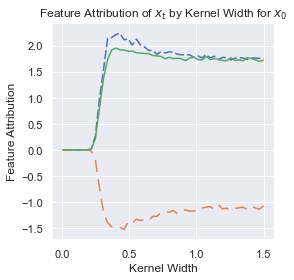

In [241]:
k = 0
j = 0
f, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))
for i in range(np.shape(temp_vals)[1]):
    sns.lineplot(x = kernel_width_range, y=temp_vals[:,i,j,k], ax=axs, style = True, dashes = lines_[i], legend = None)
    
    axs.set_title(r"Feature Attribution of $x_t$ by Kernel Width for $x_0$")
    axs.set_xlabel('Kernel Width')
    axs.set_ylabel('Feature Attribution')
    #axs.lines[i].set_linestyle("--")

f.tight_layout()


f.savefig("Images/LimeCovergenceStudyx0.svg", dpi='figure')

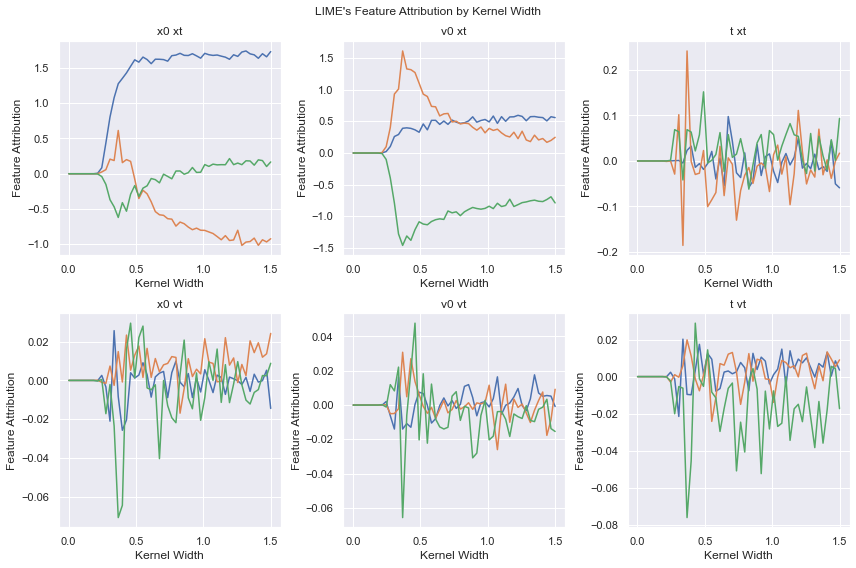

In [231]:
f

In [222]:
np.shape(temp_vals[:,:,:,:].sum(axis = 1))

(50, 3, 2)

In [1]:
lines_ = [[(6,2)], [(8,5)], [(1,0)], [(3,3)]]
f, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4,4,4]))

feat_arr = [r"$x_0$", r"$v_0$", r"$t$"]
label_arr = [r"$x_t$", r"$v_t$"]
for i in range(np.shape(temp_vals)[1]):
    for j in range(np.shape(temp_vals)[2]):
        for k in range(np.shape(temp_vals)[3]):
            sns.lineplot(x = kernel_width_range, y=temp_vals[:,i,j,k], ax=axs[k, j], 
                         style = True, dashes = lines_[i], legend = None)
            axs[k, j].set_title("LIME Attribution of " + feat_arr[j] + " to " + label_arr[k])

            axs[k, j].set_xlabel('Kernel Width')
            axs[k, j].set_ylabel('Feature Attribution')

f.suptitle("LIME's Feature Attribution by Kernel Width", fontsize = 16)
f.tight_layout()
f.savefig("Images/LimeConvergenceStudy.svg", dpi='figure')


NameError: name 'plt' is not defined

In [286]:
with open('Convergence_lime_plot', 'wb') as file_pi:
    pickle.dump(f, file_pi)

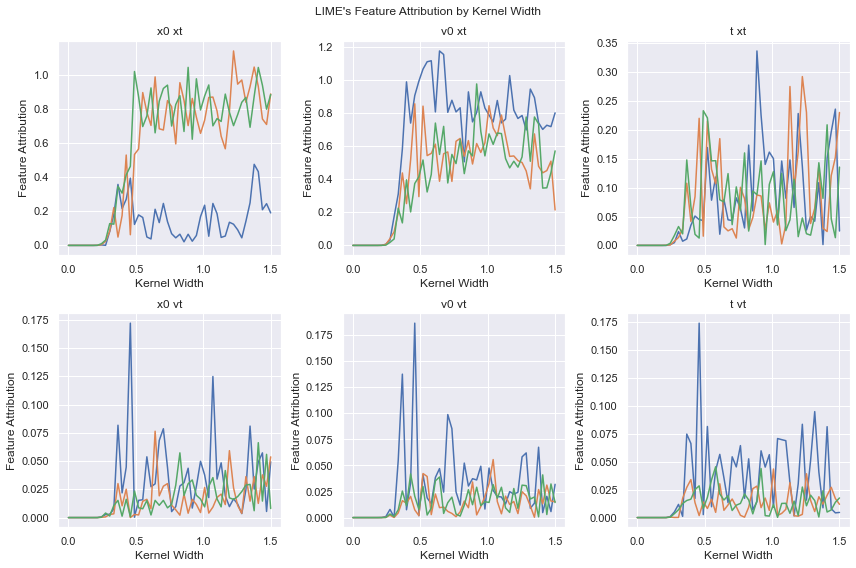

In [219]:
f, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4,4,4]))

for i in range(np.shape(temp_vals)[1]):
    for j in range(np.shape(temp_vals)[2]):
        for k in range(np.shape(temp_vals)[3]):
            sns.lineplot(x = kernel_width_range, y=np.abs(temp_vals[:,i,j,k]), ax=axs[k, j])
            axs[k, j].set_title(duffing.features[j] + " " + duffing.labels[k])

            axs[k, j].set_xlabel('Kernel Width')
            axs[k, j].set_ylabel('Feature Attribution')
            
f.suptitle("LIME's Feature Attribution by Kernel Width")

f.tight_layout()

# Numeric Explainer Convergence Study

In [263]:
class NumericExplainer():
    """
        Pretty Brute force numerical gradient calculation for
        explainability of a known function
    """
    def __init__(self, f, features, labels,  h=0.01):
        """
            Initialises with some configurations for the gradient calculation
            as well as the function being differentiated.
            
            Inputs
            --------
            f : function that takes a pandas.DataFrame and outputs a 2d np.array.
            features : list of features in the pd.DataFrame for which we are to 
                differentiate f.
            labels : list of features in the np.array.
        """
        self.f = f.predict
        self.features = features
        self.labels = labels
        self.h = h
        
    def gradient(self, X_val, feature):
        """
            Numerical Gradient Calculation by way of a CFD method.
            Inputs
            --------
            X_val : pandas.DataFrame with columns: features and values at
                which we want to take the numerical gradient.
            feature : feature by which we want to differentiate.
        """
        X_prime_plus = X_val.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + self.h
        X_prime_minus = X_val.copy()
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - self.h
        
        grad = (self.f(X_prime_plus) - self.f(X_prime_minus))/(2*self.h)
        
        return grad
    def feature_att(self, X):
        """
            Calculates the Gradients for all Entries in X, for each
            feature and label combination.
            
            Inputs
            --------
            X : pandas.DataFrame with columns:features and values at
                which we want to differentiate.
            Returns
            --------
            self.__atts : [np.array[...],np.array[...]] of gradients at
                each of the input points. Calculated for each label and stacked.
        """
        self.atts = None
        first_run = True
        for i,__label in enumerate(self.labels):
            grads = self.gradient(X, self.features[0])[:,i]
            for __feat in self.features[1:]:
                grads = np.vstack((grads,self.gradient(X, __feat)[:,i]))
            normalised_grads = np.abs(grads)/np.sum(np.abs(grads),axis=0)
            if first_run:
                self.__atts = grads.transpose()
                self.__normalised = normalised_grads.transpose()
                first_run = False
            else:
                self.__atts = [self.__atts, grads.transpose()]
                        
        return self.__atts#, self.__normalised


In [273]:
numeric_width_range = np.linspace(0,10,20)

#background = shap.sample(X_test, 100)
#choice = X_test.iloc[np.sort(np.random.choice(X_test.shape[0], 100, replace =False))]

num_vals = np.empty((20,3,3,2))

big_df = pd.DataFrame()

for j, width in enumerate(numeric_width_range):
    print(j)
    temp_explainer = NumericExplainer(model, duffing.features, duffing.labels, h = 10**(-j))
    num_vals_vals = temp_explainer.feature_att(choice.iloc[:5])
    num_vals[j,:,:,0] = num_vals_vals[0]
    num_vals[j,:,:,1] = num_vals_vals[1]
    temp_explainer = None

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


invalid value encountered in true_divide
invalid value encountered in true_divide


18


invalid value encountered in true_divide
invalid value encountered in true_divide


19


invalid value encountered in true_divide
invalid value encountered in true_divide


divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log


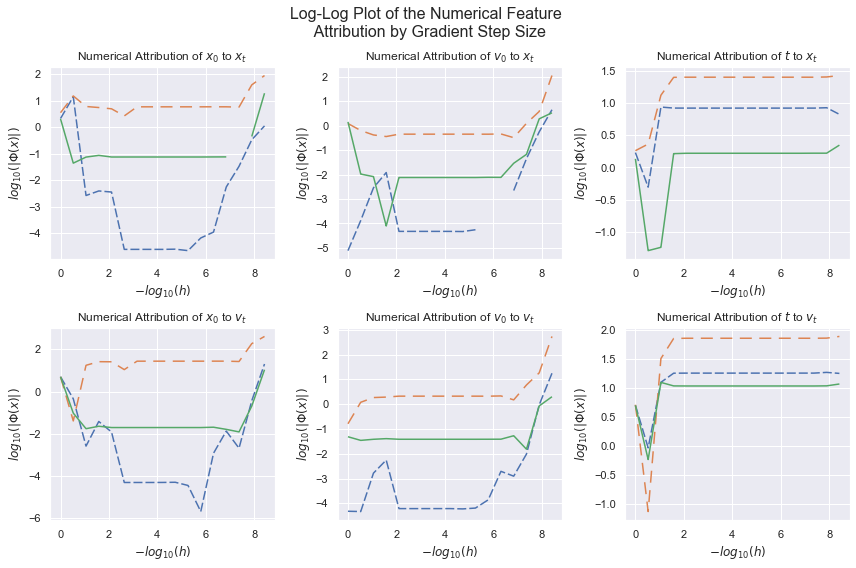

In [295]:
f, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4,4,4]))

for i in range(np.shape(num_vals)[1]):
    for j in range(np.shape(num_vals)[2]):
        for k in range(np.shape(num_vals)[3]):
            sns.lineplot(x = numeric_width_range, y=np.log(np.abs(num_vals[:,i,j,k]))/np.log(10), 
                         ax=axs[k, j], style = True, dashes = lines_[i], legend = None)
            axs[k, j].set_title("Numerical Attribution of " + feat_arr[j] + " to " + label_arr[k])

            axs[k, j].set_xlabel(r'$-log_{10}(h)$')
            axs[k, j].set_ylabel(r"$log_{10}(|\Phi (x)|)$")
            
f.suptitle("Log-Log Plot of the Numerical Feature \n Attribution by Gradient Step Size", fontsize = 16)
f.tight_layout()
f.savefig("Images/NumericalConvergenceStudy.svg", dpi='figure')


In [296]:
#with open('Convergence_numeric_plot', 'wb') as file_pi:
#    pickle.dump(f, file_pi)

In [52]:
f = pickle.load(open('Convergence_numeric_plot', "rb"))

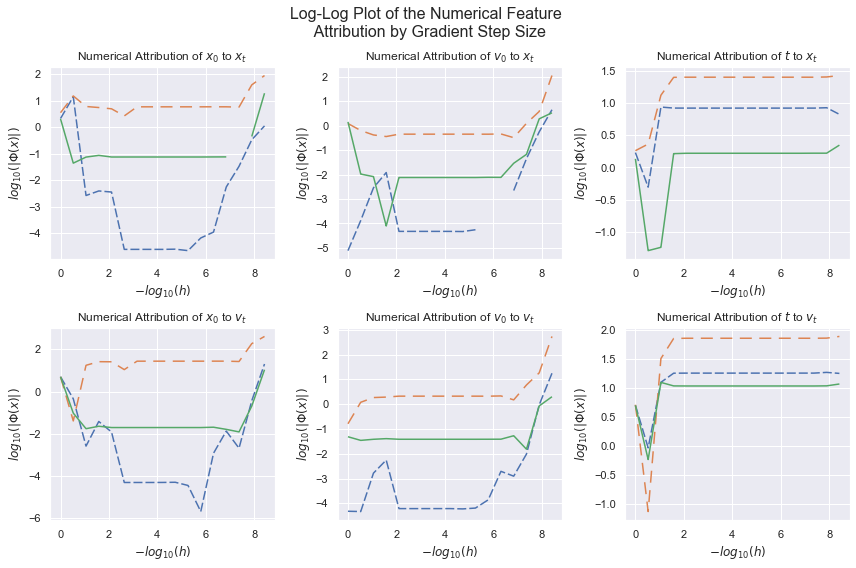

In [53]:
f

In [58]:
f.axes[0].set_xlabel(None)
f.axes[1].set_xlabel(None)
f.axes[2].set_xlabel(None)
f.axes[1].set_ylabel(None)
f.axes[2].set_ylabel(None)
f.axes[4].set_ylabel(None)
f.axes[5].set_ylabel(None)

for i in range(6):
    f.axes[i].set_title(None)

f.axes[0].set_ylabel(r"$\log_{10}(|\Phi _{x_t}(x)|)$", fontsize = 20)
f.axes[3].set_ylabel(r"$\log_{10}(|\Phi _{v_t}(x)|)$", fontsize = 20)

f.axes[3].set_xlabel(r"$\log_{10}(-h)$", fontsize = 20)
f.axes[4].set_xlabel(r"$\log_{10}(-h)$", fontsize = 20)
f.axes[5].set_xlabel(r"$\log_{10}(-h)$", fontsize = 20)

f.suptitle(None)
f.tight_layout()

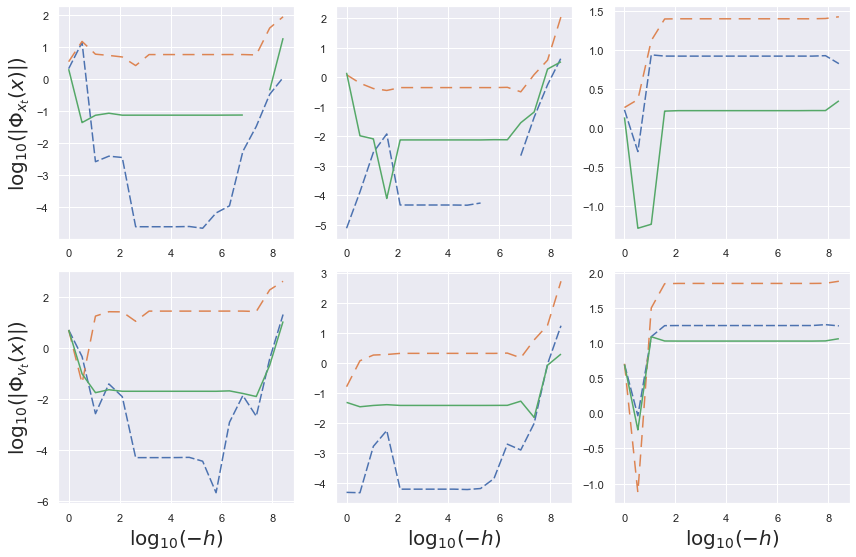

In [59]:
f

In [48]:
f.axes[0].set_xlabel(None)
f.axes[1].set_xlabel(None)
f.axes[2].set_xlabel(None)
f.axes[1].set_ylabel(None)
f.axes[2].set_ylabel(None)
f.axes[4].set_ylabel(None)
f.axes[5].set_ylabel(None)

for i in range(3):
    f.axes[i].set_title(None)

f.axes[0].set_ylabel(r"Contribution to $x_t$", fontsize = 20)
f.axes[3].set_ylabel(r"Contribution to $v_t$", fontsize = 20)

f.axes[3].set_xlabel(r"$x_0$ Kernel Width", fontsize = 20)
f.axes[4].set_xlabel(r"$v_0$ Kernel Width", fontsize = 20)
f.axes[5].set_xlabel(r"$t$ Kernel Width", fontsize = 20)

f.suptitle(None)
f.tight_layout()

In [60]:
f.savefig("Images/NumericConvergenceStudy.svg", dpi='figure')

In [50]:
f.savefig("Images/LimeConvergenceStudy.svg", dpi='figure')

In [ ]:
        elif explainer == "numeric":
            temp_explainer = NumericExplainer(model, duffing.features, duffing.labels, h = 0.001)
            temp_vals = temp_explainer.feature_att(choice)

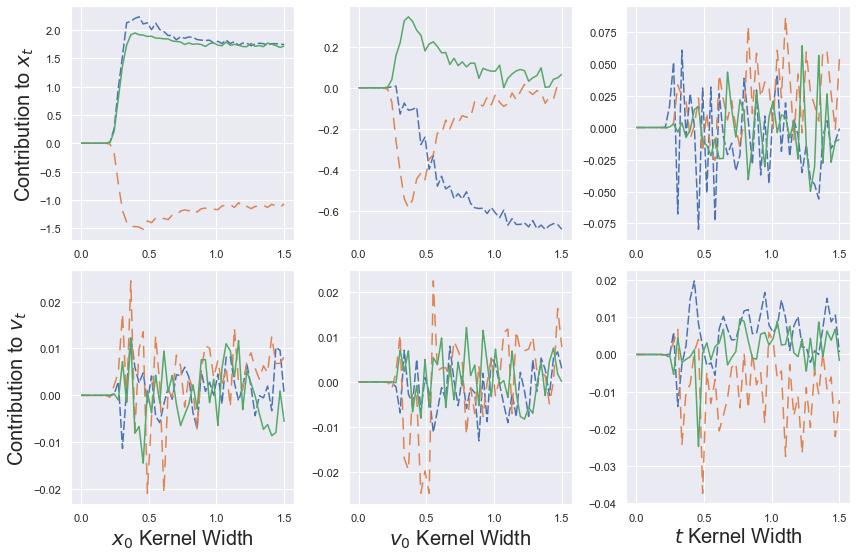

In [51]:
f